<a href="https://colab.research.google.com/github/yohan2001colombo/pyTorch/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random

 Unlike traditional deep neural networks where each dense layer has distinct weight matrices. RNNs use shared weights across time steps, allowing them to remember information over sequences.

Blog Tutorial
link : https://solardevs.com/blog/rnn-from-scratch-pytorch/

In [ ]:
class RNN(nn.Model):
  """
    Basic RNN block. This represents a single layer of RNN
  """
  def __init__(self,input_size,hidden_size,output_size):
    self.input_size = input_size
    self.hiden_size = hidden_size
    self.output_size = output_size
    self.batch_size = batch_size

    self.i2h = nn.Linear(input_size,hidden_size)
    self.h2h = nn.Linear(hidden_size,hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)

  def forward(self,x,hidden_state):
    """
        Returns computed output and tanh(i2h + h2h)
        Inputs
        ------
        x: Input vector
        hidden_state: Previous hidden state
        Outputs
        -------
        out: Linear output (without activation because of how pytorch works)
        hidden_state: New hidden state matrix
        """
    x = self.i2h(x)
    hidden_state = self.h2h(hidden_state)
    hidden_state = torch.tanh(x+hidden_state)
    out = self.h2o(hidden_state)
    return out,hidden_state

  def init_zero_hidden(self,batch_size=1) -> torch.Tensor:
    """
				Helper function.
        Returns a hidden state with specified batch size. Defaults to 1
        """
    return torch.zeros(batch_size, self.hidden_size, requires_grad=False)





tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

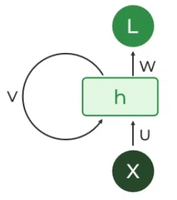

Recurrent Neural Network Architecture
RNNs share similarities in input and output structures with other deep learning architectures but differ significantly in how information flows from input to output. Unlike traditional deep neural networks where each dense layer has distinct weight matrices. RNNs use shared weights across time steps, allowing them to remember information over sequences.

In RNNs the hidden state
H
i
is calculated for every input
X
i

​
 ​ to retain sequential dependencies. The computations follow these core formulas:

1. Hidden State Calculation:

h
=
σ
(
U
⋅
X
+
W
⋅
h
t
−
1
+
B
)


Here:

h
represents the current hidden state.
U
and
W
are weight matrices.
B
is the bias.
2. Output Calculation:

Y
=
O
(
V
⋅
h
+
C
)


The output
Y is calculated by applying
O
an activation function to the weighted hidden state where
V and
C
represent weights and bias.

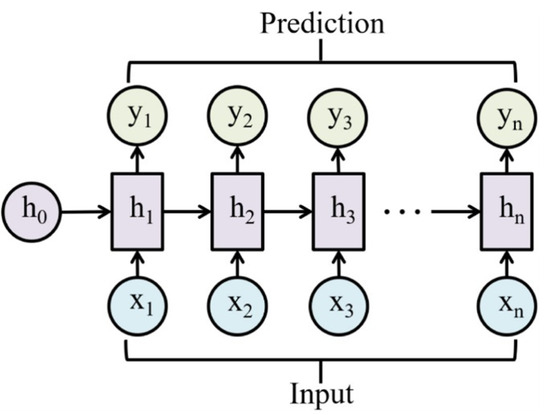

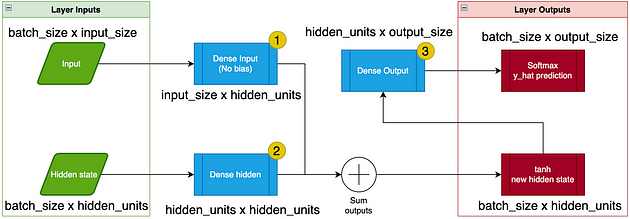

Dimensions resulting from each matrix dot product (yellow indicators)

1. batch_size x hidden_units
2. batch_size x hidden_units
3. batch_size x output size

Training with batches
Feeding a Recurrent Neural Network in batches always computes way faster (10x faster easily), and Recurrent Neural Networks are no exception. Training with batches will not improve performance in any way tho, so if your NN doesn’t work with a single training example at a time, it won’t work with 10 or 100.

The Recurrent Neural Network I show as example is trained with text, one character at a time, so the training function should feed 1 character of the whole text at a time. I save a ton of time by doing this with batches. So I can feed any number of batches for every epoch.

Each epoch of the training goes through the whole text and then I iterate through each character. After I iterated the whole sequence I then compute the loss and the gradients, to then optimize the parameters by doing optimizer.step. It is worth mentioning that cliping is useful on this type of RNNs

After each epoch I also generate text to see how the network is doing and improving.

In [ ]:
def train (model: RNN,data : DataLoader, epochs:int, optimizer: optim.Optimizer):

  train_losses = {}
  model.to(device)

  model.train()
  print("=> Starting training")

  for epoch in range(epochs):
    epoch_losses = list()
    for X,Y in data:
      # skip batch if it doesn't match with the batch_aize
      if X.shape[0] != model.batch_size:
        continue
      hidden = model.init_zero_hidden(batch_size=model.batch_size)

      # send tensors to device
      model.zero_grad()

      loss = 0

      for c in range(X.shape[1]):
        out,hidden = model(X[:,c].reshape(X.shape[0],1),hidden)
        l = loss_fn(out, Y[:,c].long())
        loss +=1





In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Step 1: Make your custom dataset
class MyDataset(Dataset):
    def __init__(self):
        self.data = torch.arange(10)  # just 0-9 for demo

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Step 2: Use DataLoader to batch it
dataset = MyDataset()
loader = DataLoader(dataset, batch_size=2, shuffle=False)

# Step 3: Iterate through the loader
for batch in loader:
    print(batch)


tensor([1, 2])
tensor([3, 4])
tensor([5, 6])
tensor([7, 8])


IndexError: index 10 is out of bounds for dimension 0 with size 10

In [ ]:
from google.colab import files
uploaded = files.upload()  # This will prompt a file upload window


Saving stroy.txt to stroy.txt


In [ ]:
for key,value in uploaded.items():
  data = value

In [ ]:
import re
text = data.decode('utf-8')
cleaned = re.sub(r'\s+', ' ', text).strip()
cleaned

"For several generations, stories from Africa have traditionally been passed down by word of mouth. Often, after a hard day’s work, the adults would gather the children together by moonlight, around a village fire and tell stories. This was traditionally called 'Tales by Moonlight'. Usually, the stories are meant to prepare young people for life, and so each story taught a lesson or moral. In the African folktales, the stories reflect the culture where diverse types of animals abound. The animals and birds are often accorded human attributes, so it is not uncommon to find animals talking, singing, or demonstrating other human characteristics such as greed, jealousy, honesty, etc. The setting in many of the stories exposes the reader to the land form and climate within that region of Africa. References are often made to different seasons such as the 'dry' or 'rainy' season and their various effects on the surrounding vegetation and animal life."

In [ ]:
class TextDataset(Dataset):

  def __init__(self,text_data:str,seq_length:int=25) -> None:
     self.chars = sorted(list(set(text_data)))
     self.data_size, self.vocab_size = len(text_data), len(self.chars)
     self.char_to_idx = {ch:i for i,ch in enumerate(self.chars)}
     self.idx_to_char = {i:ch for i,ch in enumerate(self.chars)}
     self.seq_length = seq_length
     self.X = self.string_to_vector(text_data)

  @property
  def X_string(self) -> str:

    return self.vector_to_string(self.X)


  @property
  def X_vector(self) -> list[int]:
    return self.X

  # property makes a method behave like a variable
  def __len__(self) -> int:
    return int(len(self.X)/self.seq_length-1)

  def __getitem__(self,idx) -> tuple[torch.Tensor,torch.Tensor]:

    start_idx = idx*self.seq_length
    end_idx = (idx+1)*self.seq_length

    X = torch.tensor(self.X[start_idx:end_idx]).float()
    Y = torch.tensor(self.X[start_idx+1:end_idx+1]).float()

    return X,Y

  def string_to_vector(self,name:str) -> list[int]:
    vector = list()
    for s in name:
      vector.append(self.char_to_idx[s])
    return vector

  def vector_to_string(self,vector:list[int]) -> str:
    vector_string = ""
    for i in vector:
        vector_string += self.idx_to_char[i]
    return vector_string




In [ ]:
data = cleaned.lower()
data[1:]


"or several generations, stories from africa have traditionally been passed down by word of mouth. often, after a hard day’s work, the adults would gather the children together by moonlight, around a village fire and tell stories. this was traditionally called 'tales by moonlight'. usually, the stories are meant to prepare young people for life, and so each story taught a lesson or moral. in the african folktales, the stories reflect the culture where diverse types of animals abound. the animals and birds are often accorded human attributes, so it is not uncommon to find animals talking, singing, or demonstrating other human characteristics such as greed, jealousy, honesty, etc. the setting in many of the stories exposes the reader to the land form and climate within that region of africa. references are often made to different seasons such as the 'dry' or 'rainy' season and their various effects on the surrounding vegetation and animal life."

In [ ]:
text_dataset = TextDataset(data[1:],seq_length=10)

In [ ]:
seq_length = 10
batch_size = 5
text_dataset = TextDataset(data, seq_length=seq_length)
text_dataloader = DataLoader(text_dataset, batch_size)

In [ ]:
for X,y in text_dataloader:
  print(X.shape)
  print(y)


torch.Size([5, 10])
tensor([[18., 20.,  0., 21.,  8., 24.,  8., 20.,  4., 15.],
        [ 0., 10.,  8., 17.,  8., 20.,  4., 22., 12., 18.],
        [17., 21.,  2.,  0., 21., 22., 18., 20., 12.,  8.],
        [21.,  0.,  9., 20., 18., 16.,  0.,  4.,  9., 20.],
        [12.,  6.,  4.,  0., 11.,  4., 24.,  8.,  0., 22.]])
torch.Size([5, 10])
tensor([[20.,  4.,  7., 12., 22., 12., 18., 17.,  4., 15.],
        [15., 27.,  0.,  5.,  8.,  8., 17.,  0., 19.,  4.],
        [21., 21.,  8.,  7.,  0.,  7., 18., 25., 17.,  0.],
        [ 5., 27.,  0., 25., 18., 20.,  7.,  0., 18.,  9.],
        [ 0., 16., 18., 23., 22., 11.,  3.,  0., 18.,  9.]])
torch.Size([5, 10])
tensor([[22.,  8., 17.,  2.,  0.,  4.,  9., 22.,  8., 20.],
        [ 0.,  4.,  0., 11.,  4., 20.,  7.,  0.,  7.,  4.],
        [27., 28., 21.,  0., 25., 18., 20., 14.,  2.,  0.],
        [22., 11.,  8.,  0.,  4.,  7., 23., 15., 22., 21.],
        [ 0., 25., 18., 23., 15.,  7.,  0., 10.,  4., 22.]])
torch.Size([5, 10])
tensor([[11.,  8.

In [ ]:
chars = sorted(list(set(data)))
idx_to_char = {i:ch for i, ch in enumerate(chars)}
char_to_idx = {ch:i for i, ch in enumerate(chars)}

In [ ]:
char_to_idx

{' ': 0,
 "'": 1,
 ',': 2,
 '.': 3,
 'a': 4,
 'b': 5,
 'c': 6,
 'd': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'h': 11,
 'i': 12,
 'j': 13,
 'k': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 '’': 28}

In [ ]:
vector = list()
for s in cleaned:
  print(s)
  vector.append(char_to_idx[s])


F
o
r
 
s
e
v
e
r
a
l
 
g
e
n
e
r
a
t
i
o
n
s
,
 
s
t
o
r
i
e
s
 
f
r
o
m
 
A
f
r
i
c
a
 
h
a
v
e
 
t
r
a
d
i
t
i
o
n
a
l
l
y
 
b
e
e
n
 
p
a
s
s
e
d
 
d
o
w
n
 
b
y
 
w
o
r
d
 
o
f
 
m
o
u
t
h
.
 
O
f
t
e
n
,
 
a
f
t
e
r
 
a
 
h
a
r
d
 
d
a
y
’
s
 
w
o
r
k
,
 
t
h
e
 
a
d
u
l
t
s
 
w
o
u
l
d
 
g
a
t
h
e
r
 
t
h
e
 
c
h
i
l
d
r
e
n
 
t
o
g
e
t
h
e
r
 
b
y
 
m
o
o
n
l
i
g
h
t
,
 
a
r
o
u
n
d
 
a
 
v
i
l
l
a
g
e
 
f
i
r
e
 
a
n
d
 
t
e
l
l
 
s
t
o
r
i
e
s
.
 
T
h
i
s
 
w
a
s
 
t
r
a
d
i
t
i
o
n
a
l
l
y
 
c
a
l
l
e
d
 
'
T
a
l
e
s
 
b
y
 
M
o
o
n
l
i
g
h
t
'
.
 
U
s
u
a
l
l
y
,
 
t
h
e
 
s
t
o
r
i
e
s
 
a
r
e
 
m
e
a
n
t
 
t
o
 
p
r
e
p
a
r
e
 
y
o
u
n
g
 
p
e
o
p
l
e
 
f
o
r
 
l
i
f
e
,
 
a
n
d
 
s
o
 
e
a
c
h
 
s
t
o
r
y
 
t
a
u
g
h
t
 
a
 
l
e
s
s
o
n
 
o
r
 
m
o
r
a
l
.
 
I
n
 
t
h
e
 
A
f
r
i
c
a
n
 
f
o
l
k
t
a
l
e
s
,
 
t
h
e
 
s
t
o
r
i
e
s
 
r
e
f
l
e
c
t
 
t
h
e
 
c
u
l
t
u
r
e
 
w
h
e
r
e
 
d
i
v
e
r
s
e
 
t
y
p
e
s
 
o
f
 
a
n
i
m
a
l
s
 
a
b
o
u
n
d
.
 
T
h
e
 
a
n
i
m
a
l
s


In [ ]:
char_to_idx

{' ': 0,
 "'": 1,
 ',': 2,
 '.': 3,
 'A': 4,
 'F': 5,
 'I': 6,
 'M': 7,
 'O': 8,
 'R': 9,
 'T': 10,
 'U': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'k': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'x': 34,
 'y': 35,
 '’': 36}